In [1]:
import numpy as np
from utils import *
import matplotlib.pyplot as plt
import pandas as pd
import umap
from sklearn import cluster
from sklearn import decomposition
import matplotlib.transforms as mtransforms
from matplotlib.patches import FancyBboxPatch

In [2]:
def spline_windowed(noise=0.3, t_steps=24*14):
    _, patient_list = load_data()
    window_df = window_data()
    groups = int(np.max(window_df['Group'].values)+1)
    ptnum = {}
    for j, patient in enumerate(sorted(patient_list)):
        ptnum[patient] = j
    spline_data = np.zeros((groups, t_steps+1))
    t_values = np.linspace(0, 14, t_steps)
    for a, g in window_df.groupby('Group'):
        time = g['Time']
        pain = g['Pain']
        spl = interpolate.interp1d(time, pain, bounds_error=False, kind='nearest', fill_value='extrapolate', assume_sorted=True)
        spline_data[a, :-1] = spl(t_values) + np.random.normal(scale=noise, size=(t_steps,))
        spline_data[a, -1] = ptnum[g['Patient'][0]]
    return spline_data

In [3]:
splinedata = spline_windowed(noise=1.5)

In [4]:
for row in splinedata[:, :-1]:
    plt.plot(np.linspace(0, 14, len(row)), row)
plt.figure()
drmodel = decomposition.PCA(n_components=10)
W = drmodel.fit_transform(splinedata[:, :-1])
plt.scatter(W[:, 0], W[:, 1])

[[1.         0.         1.         ... 0.         0.         0.        ]
 [0.         1.         1.         ... 0.         0.         0.        ]
 [1.         1.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.38009506]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.38009506 0.         1.        ]]


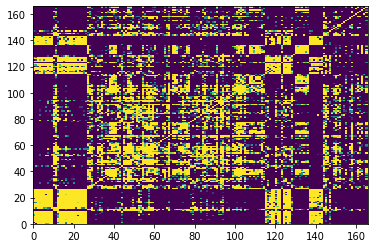

In [5]:
def affinity(data):
    Nsamples = len(data[:, 0])
    affmatrix = np.zeros((Nsamples, Nsamples))
    for i in range(Nsamples):
        for j in range(i, Nsamples):
            row_i = data[i, :]
            row_j = data[j, :]
            affinity_ij = 10-np.max(np.abs(row_i-row_j))
            affmatrix[i, j] = affinity_ij
            affmatrix[j, i] = affinity_ij
    affmatrix[affmatrix<0] = 0
    affmatrix[affmatrix>1] = 1
    return affmatrix
print(affinity(splinedata[:, :-1]))
plt.pcolormesh(affinity(splinedata[:, :-1]))

[2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 0 0 0 0 0 0 0 0 1
 0 1 1 1 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 1
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1
 1 1 1 1 2 0 2 2 2 0 2 2 1 2 2 2 2 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 0 0 0 2
 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1]


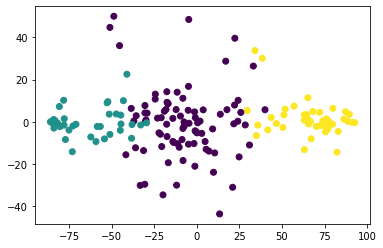

In [6]:
clusterer = cluster.SpectralClustering(n_clusters=3, affinity='precomputed')
clusterer.fit(affinity(splinedata[:, :-1]))
# plt.pcolormesh(clusterer.affinity_matrix_.toarray())
print(clusterer.labels_)
plt.figure()
plt.scatter(W[:, 0], W[:, 1], c=clusterer.labels_)

(166, 166)
166


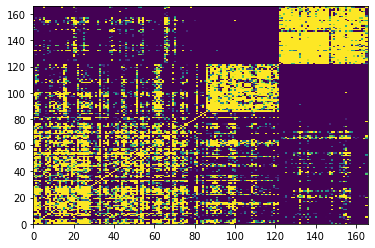

In [7]:
coms = []
for c in np.unique(clusterer.labels_):
    coms.append(list(np.where(clusterer.labels_==c)[0]))
# print(coms)
affmatrix = affinity(splinedata[:, :-1])
print(affmatrix.shape)
print(len(coms[0]+coms[1]+coms[2]))
plt.pcolormesh(reorder_matrix(affmatrix, coms))

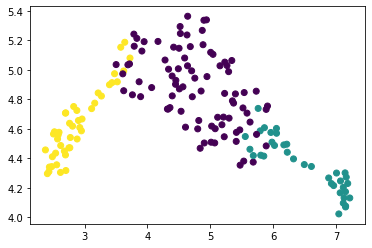

In [8]:
umapprocess = umap.UMAP(metric='euclidean')
u = umapprocess.fit_transform(splinedata[:, :-1])
u = u/np.std(u)
plt.scatter(u[:, 0], u[:, 1], c=clusterer.labels_)

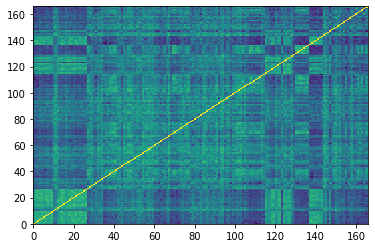

In [9]:
data = splinedata[:, :-1]
affinity = np.zeros((data.shape[0], data.shape[0]))
def norm(row):
    return np.sqrt(np.dot(row, row))
for i in range(data.shape[0]):
    for j in range(i+1, data.shape[0]):
        xi = data[i, :]# + np.random.normal(scale=0.1, size=(data.shape[1],))
        xj = data[j, :]# + np.random.normal(scale=0.1, size=(data.shape[1],))
        a_ij = -np.max(np.abs(xi-xj))/10
#         a_ij = np.dot(xi, xj)/(norm(xi)*norm(xj))
#         if np.isnan(a_ij) or np.isinf(a_ij):
#             a_ij = 0
        affinity[i, j] = a_ij
        affinity[j, i] = a_ij
plt.pcolormesh(affinity)

(array([   6.,   72.,  296.,  806., 1710., 2338., 3126., 3710., 3972.,
        4048., 3274., 2404., 1248.,  366.,   14.,    0.,    0.,    0.,
           0.,  166.]),
 array([-1.88647493, -1.79215119, -1.69782744, -1.60350369, -1.50917995,
        -1.4148562 , -1.32053245, -1.22620871, -1.13188496, -1.03756121,
        -0.94323747, -0.84891372, -0.75458997, -0.66026623, -0.56594248,
        -0.47161873, -0.37729499, -0.28297124, -0.18864749, -0.09432375,
         0.        ]),
 <BarContainer object of 20 artists>)

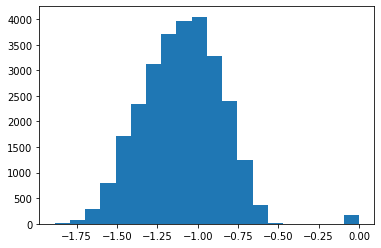

In [10]:
plt.hist(affinity.ravel(), bins=20)

In [11]:
np.sum(np.isnan(affinity.ravel()))
np.sum(np.isinf(affinity.ravel()))

0

In [12]:
sc = cluster.SpectralClustering(n_clusters=2, affinity='precomputed')

In [13]:
com = sc.fit(affinity)
communities = [list(np.argwhere(com.labels_==j).ravel()) for j in np.unique(com.labels_)]

/home/gknave/.local/lib/python3.8/site-packages/scipy/sparse/csgraph/_laplacian.py:118: RuntimeWarning: invalid value encountered in sqrt
  w = np.where(isolated_node_mask, 1, np.sqrt(w))


ValueError: array must not contain infs or NaNs

In [14]:
plt.pcolormesh(reorder_matrix(affinity, communities))

NameError: name 'communities' is not defined

In [15]:
communities

NameError: name 'communities' is not defined

In [16]:
for c in communities[1]:
    plt.plot(data[c, :])

NameError: name 'communities' is not defined

In [19]:
from scipy import io

In [20]:
data = interpolated_synth()

In [21]:
data

array([[1.04507059, 1.04507059, 1.04507059, ..., 2.6533249 , 2.6533249 ,
        2.6533249 ],
       [2.6168516 , 2.6168516 , 2.6168516 , ..., 0.94101498, 0.94101498,
        0.94101498],
       [1.29400952, 1.29400952, 1.29400952, ..., 2.28035865, 2.28035865,
        2.28035865],
       ...,
       [8.90496246, 8.90496246, 8.90496246, ..., 6.44009989, 6.44009989,
        6.44009989],
       [8.2909942 , 8.2909942 , 8.2909942 , ..., 7.03738852, 7.03738852,
        7.03738852],
       [8.71608148, 8.71608148, 8.71608148, ..., 9.80038632, 9.80038632,
        9.80038632]])

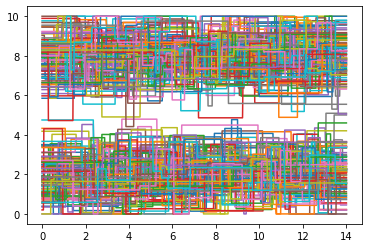

In [22]:
for row in data:
    plt.plot(np.linspace(0, 14, len(row)), row)

In [23]:
def hausdorff(row_i, row_j):
    return (10-np.max(np.abs(row_i-row_j)))/10

def integral(row_i, row_j):
    mean_difference = np.sum(np.abs(row_i-row_j))/len(row_i)
    return (10-mean_difference)/10

def cosine(row_i, row_j):
    similarity = np.dot(row_i, row_j)/(np.sqrt(np.dot(row_i, row_i))*np.sqrt(np.dot(row_j, row_j)))
    if not np.isinf(similarity):
        return similarity
    else:
        return 0

def affinity(data, similarity=hausdorff):
    Nsamples = len(data[:, 0])
    affmatrix = np.zeros((Nsamples, Nsamples))
    for i in range(Nsamples):
        for j in range(i, Nsamples):
            row_i = data[i, :]
            row_j = data[j, :]
            affinity_ij = similarity(row_i, row_j)
            affmatrix[i, j] = affinity_ij
            affmatrix[j, i] = affinity_ij
    affmatrix[affmatrix<0] = 0
    affmatrix[affmatrix>1] = 1
    return affmatrix

In [24]:
def plot_affinity(data, similarity=hausdorff):
    affmatrix = affinity(data, similarity=similarity)
    plt.figure()
    plt.pcolormesh(affmatrix)
    plt.gca().set_aspect('equal')
    plt.colorbar()

Hausdorff distance


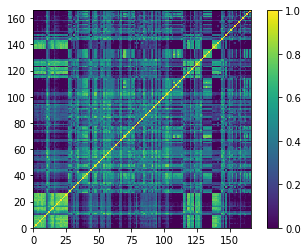

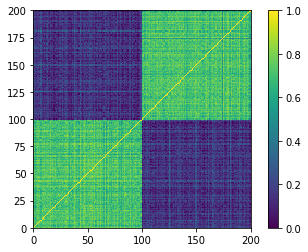

In [25]:
# for data in [spline_windowed()[:, :-1], interpolated_synth()]:
    
#     clustering = cluster.SpectralClustering(n_clusters=n_clusters, affinity='precomputed').fit(affinity_matrix)

print('Hausdorff distance')
plot_affinity(spline_windowed()[:, :-1], similarity=hausdorff)
plot_affinity(interpolated_synth(), similarity=hausdorff)

Mean distance


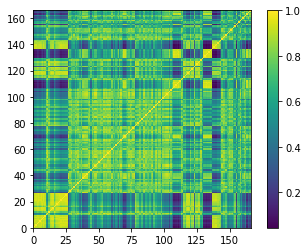

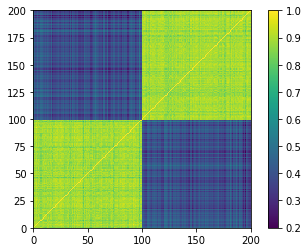

In [26]:
print('Mean distance')
plot_affinity(spline_windowed()[:, :-1], similarity=integral)
plot_affinity(interpolated_synth(), similarity=integral)

Cosine distance


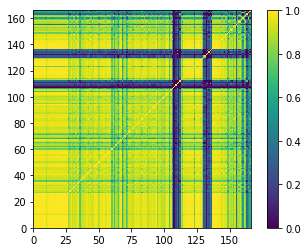

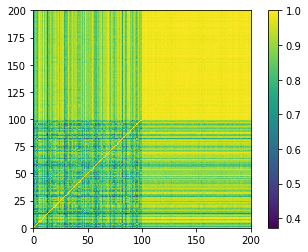

In [27]:
print('Cosine distance')
plot_affinity(spline_windowed()[:, :-1], similarity=cosine)
plot_affinity(interpolated_synth(), similarity=cosine)

In [28]:
row_i = interpolated_synth()[125, :]
row_j = interpolated_synth()[126, :]

mean_difference = np.sum(np.abs(row_i-row_j))/len(row_i)

In [29]:
def communities(labels):
    coms = []
    for c in np.unique(labels):
        coms.append(list(np.where(labels==c)[0]))
    return coms

In [30]:
def add_fancy_patch_around(ax, bb, **kwargs):
    fancy = FancyBboxPatch((bb.xmin, bb.ymin), bb.width, bb.height,
                           fc=(1, 1, 1, 0), ec=(1, 0, 1, 1),
                           **kwargs)
    ax.add_patch(fancy)
    return fancy

def community_boxes(communities, axis):
    tot_len = 0
    for c in communities:
        bb = mtransforms.Bbox([[tot_len, tot_len], [tot_len+len(c), tot_len+len(c)]])
        fancy = add_fancy_patch_around(axis, bb, boxstyle="round,pad=0.1")
        tot_len += len(c)

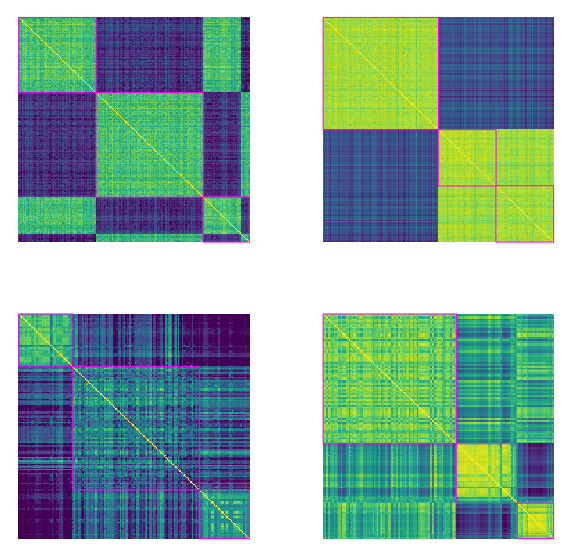

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for a, similarity in enumerate([hausdorff, integral]):
    for b, data in enumerate([interpolated_synth(), spline_windowed()[:, :-1]]):
        affinity_matrix = affinity(data, similarity=similarity)
        clustering = cluster.SpectralClustering(n_clusters=3, affinity='precomputed').fit(affinity_matrix)
        coms = communities(clustering.labels_)
        ax[b, a].pcolormesh(reorder_matrix(affinity_matrix, coms))
        community_boxes(coms, ax[b, a])
        ax[b, a].invert_yaxis()
        ax[b, a].axis('off')

In [32]:
def euclidean(row_i, row_j):
    difference = row_i-row_j
    norm = np.sqrt(np.dot(difference, difference))
    return norm

In [43]:
Nsamples = data.shape[0]
affmatrix = np.zeros((Nsamples, Nsamples))
for i in range(Nsamples):
    for j in range(i, Nsamples):
        row_i = data[i, :]
        row_j = data[j, :]
        affinity_ij = euclidean(row_i, row_j)
        affmatrix[i, j] = affinity_ij
        affmatrix[j, i] = affinity_ij
affmatrix -= np.min(affmatrix.ravel())
affmatrix /= np.max(affmatrix.ravel())
affmatrix = 1-affmatrix

(-8.41, 174.41, 174.41, -8.41)

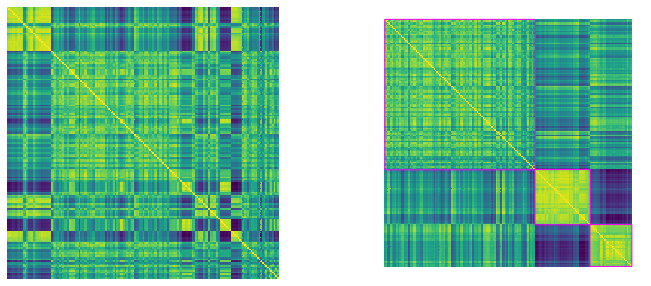

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].pcolormesh(affmatrix)
ax[0].invert_yaxis()
ax[0].set_aspect('equal')
ax[0].axis('off')

clustering = cluster.SpectralClustering(n_clusters=3, affinity='precomputed').fit(affmatrix)
coms = communities(clustering.labels_)
ax[1].pcolormesh(reorder_matrix(affmatrix, coms))
tot_len = 0
for c in coms:
    bb = mtransforms.Bbox([[tot_len, tot_len], [tot_len+len(c), tot_len+len(c)]])
    fancy = add_fancy_patch_around(ax[1], bb, boxstyle="round,pad=0.1")
    tot_len += len(c)
ax[1].invert_yaxis()
ax[1].set_aspect('equal')
ax[1].axis('off')


(-10.110000000000001, 210.11, 210.11, -10.110000000000001)

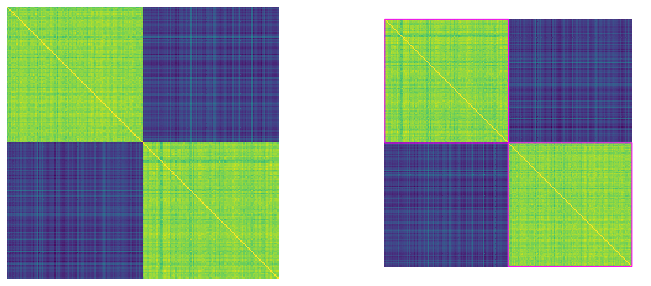

In [51]:
data = interpolated_synth()

Nsamples = data.shape[0]
affmatrix = np.zeros((Nsamples, Nsamples))
for i in range(Nsamples):
    for j in range(i, Nsamples):
        row_i = data[i, :]
        row_j = data[j, :]
        affinity_ij = euclidean(row_i, row_j)
        affmatrix[i, j] = affinity_ij
        affmatrix[j, i] = affinity_ij
affmatrix -= np.min(affmatrix.ravel())
affmatrix /= np.max(affmatrix.ravel())
affmatrix = 1-affmatrix

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].pcolormesh(affmatrix)
ax[0].invert_yaxis()
ax[0].set_aspect('equal')
ax[0].axis('off')

clustering = cluster.SpectralClustering(n_clusters=2, affinity='precomputed').fit(affmatrix)
coms = communities(clustering.labels_)
ax[1].pcolormesh(reorder_matrix(affmatrix, coms))
community_boxes(coms, ax[1])
ax[1].invert_yaxis()
ax[1].set_aspect('equal')
ax[1].axis('off')
